In [829]:
from IPython.core.display import HTML

HTML('./style/style.html')

# Presentation on Word2Vec
Glenn Abastillas | 24 March, 2020

``` ADD VISUAL OF KING - QUEEN = MAN WITH SVG ```

This notebook goes over an example implementation of Word2Vec and some existing packages that perform Word2Vec training.

Contents
  1.  Preliminary Steps
      * [Load Packages](#load_packages)
      * [Preprocess Data](#preprocess_data)
      * [Quick Background](#quick_background)
  2. [Implementation from Scratch](#implementation_from_scratch)
      * Word2Vec Flavors: Continuous Back of Words (CBOW) / Skip Grams (SG)
      * Training
      * Retrieving the trained matrix
      * Applications
  3. Using an Existing Package

__At each step, we will also cover other packages that can be used to acheive the same thing (e.g., Countvectorizer)__
  
<p class='tip banner'>This is an example of a tip.<p>
<p class='attention banner'>This is an example of an attention.<p>
<p class='warning banner'>This is an example of a warning.<p>
  
---

### Load Packages <a id="load_packages"></a>
First we import packages and clean the data.

In [773]:
import numpy as np
import spacy
from tqdm.notebook import trange, tqdm

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import brown, gutenberg, stopwords
from collections import namedtuple
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

alt.renderers.enable('notebook')
corpus = brown

We will use data from the `gutenberg` corpus and normalize the input data.

In [775]:
title = 'ca11'
sents = corpus.sents(title)
words = corpus.words(title)

print(f'Number of sentences: {len(sents):,}')
print(f'Number of words: {len(words):,}')

Number of sentences: 100
Number of words: 2,259


In [150]:
sents = ['sarah is my mother who married my father'.split(), 
         'peter is my father and best friend'.split(), 
         'my dad works all day'.split(),
         'sarah and peter live in our house but work outside the house'.split(),
         'i love my mother and father'.split(),
         'i love my mom and dad'.split(),
         'mom is at work and dad is at home'.split(),
         'alan turing is the organization that dad works for'.split(),
         '3m is where my mom works'.split(),
         'i work from home a lot'.split()]
words = [word for sent in sents for word in sent]

In [464]:
text = """"The Road Not Taken" is a narrative poem. It reads naturally or conversationally and begins as a kind of photographic depiction of a quiet moment in woods. It consists of four stanzas of 5 lines each. The first line rhymes with the third and fourth, and the second line rhymes with the fifth (ABAAB). The meter is basically iambic tetrameter, with each line having four two-syllable feet. Though in almost every line, in different positions, an iamb is replaced with an anapest. The variation of the rhythm gives naturalness, a feeling of thought occurring spontaneously, and it also affects the reader's sense of expectation.[3] In the only line that contains strictly iambs, the more regular rhythm supports the idea of a turning towards an acceptance of a kind of reality: "Though as for that the passing there … " In the final line, the way the rhyme and rhythm work together is significantly different, and catches the reader off guard.[4]

It is one of Frost's most popular works. Some have said that it is one of his most misunderstood poems, claiming that it is not simply a poem that champions the idea of "following your own path", but that the poem, they suggest, expresses some irony regarding that idea.[5][1]

Frost's biographer Lawrance Thompson suggests that the poem's narrator is "one who habitually wastes energy in regretting any choice made: belatedly but wistfully he sighs over the attractive alternative rejected".[6] Thompson also says that when introducing the poem in readings, Frost would say that the speaker was based on his friend Edward Thomas. In Frost's words, Thomas was "a person who, whichever road he went, would be sorry he didn't go the other. He was hard on himself that way."[7]

Regarding the "sigh" that is mentioned in the last stanza, it may be seen as an expression of regret or of satisfaction, but there is significance in the difference between what the speaker has just said of the two roads, and what he will say in the future.[8] According to the biographer Lawrance Thompson, as Frost was once about to read the poem, he commented to his audience, "You have to be careful of that one; it's a tricky poem—very tricky," perhaps intending to suggest the poem's ironic possibilities.[6][9] A New York Times Sunday book review on Brian Hall's 2008 biography Fall of Frost states: "Whichever way they go, they're sure to miss something good on the other path."[10]"""

In [467]:
sents = [[word.lower() for word in sent.split()] for sent in text.split('.')]
words = [word for sent in sents for word in sent]

Generate word encodings and word probabilities.

In [776]:
words = [word.lower() for word in words]

WORDS, COUNTS = np.unique(words, return_counts=True)

PROBS = COUNTS**0.75 / (COUNTS**0.75).sum()

INDEX = np.arange(WORDS.size)

VOCAB = dict(zip(WORDS, INDEX))
VOCABR = dict(zip(INDEX, WORDS))

---
##### Visual Inspection

A quick look into our corpus reveals that the most frequent sentences in our corpus are 3, 16, and 10 tokens long.

In [821]:
lengths = [len(sent) for sent in sents]
lengths_data = pd.DataFrame(lengths, columns=['Sentence Length'])
lengths_data = lengths_data['Sentence Length'].value_counts()

Let's visualize the counts of sentence length.

Text(0, 0.5, 'Counts')

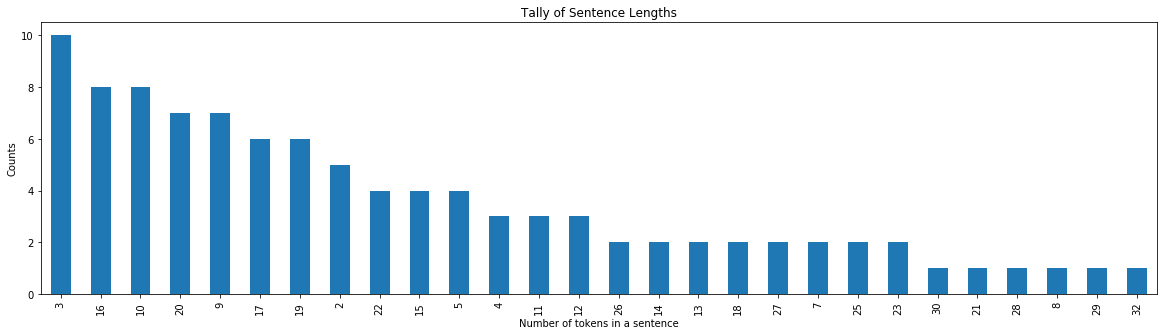

In [825]:
params = {'kind' : 'bar', 'figsize' : (20, 5), 'title' : f'Tally of Sentence Lengths'}
ax = lengths_data.plot(**params)
ax.set_xlabel('Number of tokens in a sentence')
ax.set_ylabel('Counts')

---

##### Preprocessing the Text

Next we preprocess the text to get rid of overly frequent words (e.g., `the`) and stopwords (e.g., `and`, `but`). 

\[INSERT IMAGE HERE OF CROSSED OUT STOPWORDS\]

These functions help us do that filtering.

In [831]:
stopwords_ = stopwords.words('english')

def is_stopword(token):
    ''' Check if a specified token is a stopword. '''
    try:
        return token.lower() in stopwords_
    except:
        return False

def is_valid_token(token):
    ''' Check if token is valid, i.e., not a stopword or punctuation '''
    try:
        return token.isalnum() & ~is_stopword(token)
    except:
        return False

def subsample(vocabulary, probs=PROBS, sample_rate=0.001):
    ''' Return the indices of words to be excluded '''
    p_keep = (np.sqrt(probs / sample_rate) + 1) * sample_rate / probs
    p_keep[p_keep >= 1] = 1
    return p_keep
    

##### First Normalization Step
Next, we create our `raw_text` data using the functions we just defined.

###### Subsampling

Remove overly frequent words that may not contribute much to vector meanings (e.g., the). First, generate a list of frequent words with a low probability of keeping them (e.g., $P_{keep}(w_i) < 0.75$)

<p class='attention banner'>cite this paper</p>

In [832]:
p_keep = subsample(WORDS)
exclude = [word.lower() for word in WORDS[p_keep < 0.75]]

Update the sentences with the new `exclude` filter.

<p class='attention banner'>Examplain usage of timer?</p>

In [833]:
%%time
sents = [[word.lower() for word in sent if (word.lower() not in exclude) and word.isalnum()] for sent in sents]
print(f'Number of sentences: {len(sents):,}')

Number of sentences: 100
CPU times: user 1.66 ms, sys: 805 µs, total: 2.47 ms
Wall time: 2.46 ms


##### Second Normalization Step

Using the conversion function defined above, we can convert our `normalized_sents` into `data`, which contains only integers that will be used in our Word2Vec example.

In [834]:
%%time
data = (np.array([VOCAB[token] for token in sent]) for sent in sents)

CPU times: user 200 µs, sys: 672 µs, total: 872 µs
Wall time: 882 µs


`[insert navigation here]`

---

Use this reference for later [Dimensions greater than 300 have diminishing returns](https://www.aclweb.org/anthology/D14-1162/)

### Quick Background <a id="quick_background"></a>
#### Background Into Word2Vec

<p class='warning banner'>Add images of class vector relationships</p>

* What is it?
  - <p class='content'>Quick definition (implementation of theoretical matrix bit): A method or representing words as numerical vectors, which allow us to improve the efficiency of our models as well as enable us to glean insight on how words behave in a text.</p>
  - What is does to text: The Word2Vec model converts words as strings into an array of numbers of n-dimensions by training a shallow neural network and keeping only the trained weights.
  - What the output is: The trained weights from the neural network we train are conveniently also act as the word vectors themselves in a matrix format.

<p class='warning banner'>Add images of linalg</p>
* Why do we need it?
  - Many uses in AI: Semantic analysis, entity discovery, lexical and lexical relationship analysis, and topic modeling.
  - Pros: We can do algebra with words and converting strings to numeric vectors unlocks a host of abilities that we can perform on these numeric vectors.
  - Cons: We need a large vocabulary and training can be very time and resources heavy.
 
 
<p class='warning banner'>Add classic image of king - man + woman = queen but as a rebus</p>
* What cool things can it do?
  - Condense text into a lightweight matrix
  - Provide semantic abilities
  - Enable data to have algebraic properties
 
* What are competing models?
  - Other models to represent text
  - GloVe
  - Other vectorization models

`[insert navigation here]`

---
## Implementation from Scratch <a id="implementation_from_scratch"></a>

For things example, we will create a Word2Vec language model using the data we preprocessed above. 

In this section, we will develop a **<a id="skip-gram" style="text-decoration: none; cursor: help;" title="Using the a token to predict its surroundings">Skip-gram</a>** flavored Word2Vec model.

We will:
  * Create Skip-gram windows
  * Create preliminary <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a>


###### Parameters <a id='parameters'></a>
First we define some hyperparameters that we use for training.

In [835]:
parameters = {'window_size' : 2, 'dimensions' : 100, 'learning_rate' : 0.02, 'epochs' : 50}

<p class='attention banner'>Style this table later and move to before the cell</p>
This table quickly describes what each parameter does.

Parameters | Data Type | Description
--- | :-: | :--
`window_size` | `int` | The number of target tokens before and after a central token to include
`dimensions` | `int` | The number of dimensions in hidden layer. Dimensions greater than 300 have diminishing returns `[cite]`.
`learning_rate` | `float` | How quickly our model will correct itself
`epochs` | `int` | The number of rounds the model is trained

##### Creating the Training Data <a id="creating_the_training_data"></a>

We will generate loose <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a> that will serve as input and target data when training our model.

First we filter our data to ensure we have sufficient data to window.

In [836]:
%%time
data = [sent for sent in data if sent.size >= parameters['window_size'] + 2]

print(f'Number of sentences in data: {len(data)}')

Number of sentences in data: 85
CPU times: user 1.53 ms, sys: 1.42 ms, total: 2.95 ms
Wall time: 5.63 ms


Now, we generate our one hot vectors using the `VOCAB` as a model for our vector.

Let's define a few functions to help use generate these data.

In [837]:
Datum = namedtuple('Datum', 'target context'.split())

def one_hot(token, size=WORDS.size):
    ''' Convert an input token into an integer according to a specified reference '''
    vector = np.zeros((size, 1))
    vector[token] = 1
    return vector

def generate_examples(data, examples=[], size=parameters['window_size']):
    ''' Create a example data with the structure [(context, targets), ...] '''
    for i, sentence in tqdm(enumerate(data), desc='Generating examples', total=len(data)):
        for j, token in enumerate(sentence):
            before = max(j - size, 0)
            after = j + size
            skip = j + 1

            context = one_hot(sentence[j])
            targets = np.append(sentence[before:j], sentence[skip:after])
            
            _targets = []
        
            for target in targets:
                _targets.append(one_hot(target))
                
            examples.append((context, _targets))
    
    return examples

Loop through all the sentences to generate `target` and `context` data for training.
<p class='attention'>Processing time may vary </p>

In [786]:
examples = generate_examples(data)
print(f'{len(examples)} examples')


1330 examples


`[insert navigation here]`

---

<p class='tip'>New Section</p>

### Create Layers <a id='create_layers'></a>

These matrices will serve as the layers that surround our `word2vec` layer during training.

In [642]:
weights_1 = np.random.random((WORDS.size, parameters['dimensions']))
weights_2 = np.random.random((WORDS.size, parameters['dimensions']))
print(f'Dimensions\nWeights 1 {weights_1.shape}\nWeights 2 {weights_2.shape}')

Dimensions
Weights 1 (242, 100)
Weights 2 (242, 100)


`[insert navigation here]`

---
###### Feed Forward Algorithm

The first part of a two part algorithm defining a <a id='learning-step' style='text-decoration: none; cursor: help;' title='A phase where training data are learned and errors are adjusted throughout the model'>learning step</a>. This algorithm introduces our randomly initialized model to its first evidence of real data to learn from. It then predicts a surrounding vocabulary item from it.

In [643]:
def forward(datum, weights_1=weights_1, weights_2=weights_2):
    ''' Return three matrices corresponding to the prediction, hidden layer, and output '''
    hidden = np.dot(weights_1.T, datum)
    output = np.dot(weights_2, hidden)
    prediction = softmax(output)
    return prediction, hidden, output

def softmax(datum):
    ''' Return the an array normalized to a probability '''
    e = np.exp(datum - datum.max())
    return e / e.sum()

def calculate_loss(datum, prediction):
    ''' Calculate the cross entropy for the output of a forward pass '''
    dimensions = prediction.shape[1]
    inner_sum = np.sum(datum * np.log(prediction), axis=0, keepdims=1)
    outer_sum = np.sum(inner_sum, axis=1)
    return - (1 / dimensions) * outer_sum

<p class='warning'>Old functions</p>

In [644]:
def calculate_error(prediction, context):
    ''' Return a weights with the summed prediction error '''
    error = np.zeros((prediction.size, 1))
    for subcontext in context:
        for token in subcontext:
            error += prediction - token
    return error

def backpropagate(prediction, hidden, target, context, weights_1=weights_1, weights_2=weights_2, index=INDEX):
    ''' Update weight matrices according to output from forward() '''
    error = calculate_error(prediction, context)
    
    weights_2_delta = np.outer(error, hidden)
    hidden_error = np.dot(weights_2.T, error)
    weights_1_delta = np.outer(hidden_error, target).T
    
    weights_1 -= weights_1_delta * parameters['learning_rate']
    weights_2 -= weights_2_delta * parameters['learning_rate']

`[insert navigation here]`

---
##### Training Algorithm

Having both the feed forward and backpropagation algorithms defined, we can now define a training algorithm to learn all training examples for a single <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

In [645]:
def train(examples, weights_1=weights_1, weights_2=weights_2, parameters=parameters, total=WORDS.size):
    ''' Train the Word2Vec model on our training data to generate meaningful word vectors '''
    
    epochs = trange(parameters['epochs'], desc="Training")
    loss = []
    predictions = []

    for epoch in epochs:
        data = tqdm(examples, desc=f'Epoch {epoch}', leave=False)
        for context, targets in data:
            prediction, hidden, output = forward(context)
            backpropagate(prediction, hidden, context, targets)
            predictions.append(prediction.argmax())
#             loss.append(calculate_loss(context, prediction)[0])
    return loss, predictions

In [649]:
loss[1]

[85,
 196,
 87,
 209,
 68,
 73,
 142,
 126,
 89,
 95,
 176,
 40,
 228,
 21,
 161,
 41,
 24,
 212,
 10,
 155,
 192,
 210,
 220,
 100,
 169,
 22,
 172,
 4,
 203,
 66,
 39,
 85,
 104,
 197,
 91,
 52,
 211,
 102,
 23,
 168,
 57,
 201,
 82,
 45,
 61,
 211,
 234,
 49,
 195,
 206,
 190,
 4,
 66,
 99,
 232,
 59,
 163,
 147,
 121,
 208,
 18,
 51,
 132,
 213,
 217,
 81,
 141,
 102,
 190,
 108,
 236,
 135,
 90,
 168,
 225,
 121,
 142,
 84,
 6,
 68,
 97,
 19,
 224,
 101,
 83,
 202,
 66,
 235,
 171,
 14,
 44,
 27,
 65,
 203,
 136,
 51,
 206,
 210,
 84,
 179,
 221,
 134,
 166,
 133,
 93,
 120,
 197,
 173,
 42,
 132,
 59,
 87,
 111,
 172,
 142,
 137,
 66,
 45,
 91,
 49,
 168,
 205,
 84,
 33,
 57,
 238,
 104,
 231,
 214,
 21,
 87]

`[insert navigation here]`

---
###### Test Iteration <a id='test_iteration'></a>

This cell loops through all our training data to demonstrate what happens in one training <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

<p class='warning'>Processing time may vary</p>

In [651]:
%%time
parameters['epochs'] = 10
loss = train(examples)


CPU times: user 7.42 s, sys: 217 ms, total: 7.63 s
Wall time: 7.69 s


##### Looking at Some Examples

We define some functions to inspect the output of our model.

In [652]:
def word_vector(token, model=weights_2):
    ''' Return the word vector corresponding to a token '''
    return model[token]

def similarity(vector1, vector2):
    ''' Return the cosine similarity score for two tokens input as vectors '''
    if isinstance(vector1, int):
        vector1 = word_vector(vector1)
        
    if isinstance(vector2, int):
        vector2 = word_vector(vector2)
        
    a = np.dot(vector1, vector2)
    b = np.dot(vector1, vector1)
    c = np.dot(vector2, vector2)
    return a / (np.sqrt(b) * np.sqrt(c))

We inspect randomly selected words for their similarity score where $similarity \in [-1,1]$

In [653]:
v1 = np.random.randint(0, WORDS.size)
v2 = np.random.randint(0, WORDS.size)
print(f'{VOCABR[v1]} and {VOCABR[v2]}')
similarity(v1, v2)

will and once


0.997687731599427

In [654]:
VOCAB['sorry'], VOCAB['rhymes']

(186, 169)

In [664]:
v1 = 189
v2 = 190
print(f'{VOCABR[v1]} and {VOCABR[v2]}')
similarity(v1, v2)

stanza, and stanzas


-0.5056590273259606

Test the current model trained only on a single epoch.

In [588]:
token = np.random.randint(0, WORDS.size)
a, b = weights_1[token - 1], weights_1[token]
distance = np.dot(a,b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b,b)))

print(f'Token number {token} is "{VOCABR[token]}" along with "{VOCABR[token-1]}" with cos score as {distance}')

Token number 83 is "good" along with "go," with cos score as 0.7756679016707607


In [551]:
# np.savetxt('20200326_blake-poems.csv', weights_1, delimiter=',')

`[insert navigation here]`

---
#### Using Our Trained Model

We can use our trained model to `list things we can do with our Word2Vec model from earlier`.

First, we define functions to help do those things.

In [734]:
iamb = word_vector(VOCAB['iamb'])

In [735]:
numerator = np.dot(np.array([iamb]), weights_1.T).T

In [736]:
denominator2 = np.sqrt(np.dot(iamb, iamb))

In [759]:
denominator1 = np.sqrt(weights_1 @ weights_1.T)[np.arange(242), np.arange(242)]

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [762]:
(weights_1 @ weights_1.T).min()

-6.124722184094672e+51

In [738]:
VOCABR[107], VOCABR[235], VOCABR[11]

('kind', 'words,', '(abaab)')

In [742]:
ranking = (numerator.T.flatten() / (denominator1*denominator2)).argsort()

In [747]:
WORDS[ranking][:10]

array(['almost', 'sure', 'good', 'affects', 'replaced', 'occurring',
       'conversationally', 'biography', 'something', 'fall'], dtype='<U16')

In [552]:
def topn(token, n=3, model=weights_1):
    ''' Return the top n tokens and vectors most closely related to input token '''
    
#     similarity_scores, vectors = [], []
    vector = word_vector(token, model)
    
    numerator = np.dot(np.array([vector]), model.T)
    denominator1 = np.sqrt(np.dot(vector, vector))
    denominator2 = np.sqrt(np.dot())
    

    
    
#     for vector in model:
#         similarity_scores.append(similarity(token, vector))
    
#     return np.array(similarity_scores)
        

In [553]:
res = topn(400)

IndexError: index 400 is out of bounds for axis 0 with size 242

Test with algebraic interactions of this 

In [ ]:
most_similar(994)

In [ ]:
VOCABR[994], VOCABR[8066]

In [ ]:
similarity(word_vector(343), word_vector(344)), VOCABR[343], VOCABR[344]

`[insert navigation here]`

---

### Visualize Word2Vec

We can visualize our word vectors trained using plotting packages like `matplotlib`, `seaborn`, and others. I make use of the `altair` visualization package.

<p class='tip'>Preprocessing</p>

In [560]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Declare preprocessing models.

In [665]:
pca2 = PCA(n_components=2)
pca50 = PCA(n_components=min(50, weights_1.shape[0]))
tsne = TSNE(n_components=2, perplexity=100)
scale = StandardScaler()

Normalize the vector weights so that $\mu = 0$ and $\sigma = 1$.

In [666]:
scaled_data = scale.fit_transform(weights_1)

Reduce dimensionality via PCA transform.

In [667]:
pca_data_2 = pca2.fit_transform(scaled_data)
pca_data_50 = pca50.fit_transform(scaled_data)

Reduce dimensionality via TSNE transform.

<p class='warning'> Results may vary from run to run</p>

In [668]:
%%time
tsne_data = tsne.fit_transform(pca_data_50)

CPU times: user 7.12 s, sys: 89.9 ms, total: 7.21 s
Wall time: 2.01 s


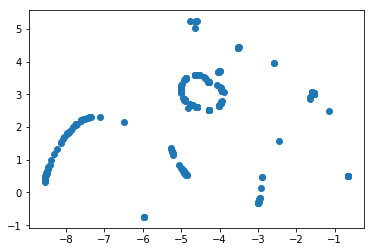

In [669]:
plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1])

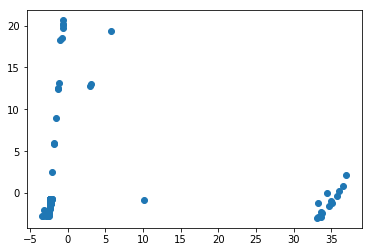

In [670]:
plt.scatter(x=pca_data_2[:,0], y=pca_data_2[:,1])

#### Visualization with Altaïr

After transforming the high-dimensional data down to 2 and 3 dimensional datasets, we can better visualize what the vectors we trained look like.

In [671]:
current = tsne_data
columns = [f'd{i}' for i in range(current.shape[-1])]
index = [f'{VOCABR[i]}' for i in range(current.shape[0])]

viz_data = pd.DataFrame(tsne_data, columns=columns, index=index).reset_index()

In [672]:
chart = alt.Chart(viz_data)

In [673]:
alt.X()

X({
  
})

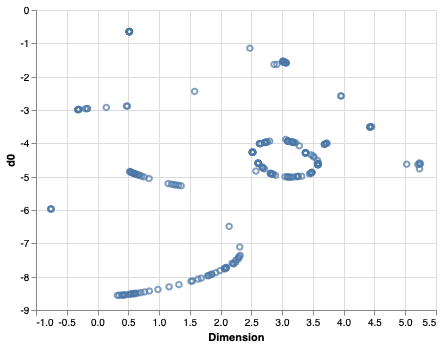

In [674]:
marked = chart.mark_point()
marked.encode(x=alt.X('d1:Q', title='Dimension'), y='d0:Q', tooltip='index').interactive(True)

In [ ]:
viz_data

---

In [ ]:
vector.shape, matrix_1.shape

In [ ]:
pred, h, u = forward(vector, matrix_1, matrix_2)
pred.shape, h.shape, u.shape

In [ ]:
VOCABR[vector.argmax()]

In [ ]:
VOCABR[pred.argmax()]

## Using an Existing Package

There are existing implementations that already exist that allow you to use Word2Vec technology out of the box.

Examples of these include:
  * SpaCy
  * gensim
  * ELMo
  * fasttext
 
 
### SpaCy

In [ ]:
nlp = spacy.load('en_core_web_sm')